# Scope Setup

In [2]:
import chipwhisperer as cw
scope = cw.scope()
target = cw.target(scope)
scope.default_setup()

In [21]:
from tqdm.notebook import trange
import numpy as np
import os

scope.io.tio1 = 'serial_tx'
scope.io.tio2 = 'serial_rx'
scope.trigger.triggers = 'nrst'

scope.gain.db = 56
scope.adc.samples = 24400
scope.adc.offset = 24400 + 24400 + 24400 + 24400 + 24400 + 24400 + 24400
scope.clock.clkgen_freq = 4000000 

# Check Trace Folder

In [24]:
import glob
import os

folderpath = 'measured_traces_170800'
filepath = 'measured_traces_170800/traces*.bin'

list_of_files = glob.glob(filepath) 
latest_file = max(list_of_files, key=os.path.getctime)
print('latest file is:',latest_file)

list = os.listdir(folderpath) 
number_files = len(list)
print('total file number is:',number_files)

ValueError: max() arg is an empty sequence

In [23]:
24400 + 24400 + 24400 + 24400 + 24400 + 24400 + 24400

170800

# Plot Real-Time Trace

In [13]:
#%run "../../chipwhisperer-fame/swaes/real_time_plot.ipynb"
#plot = real_time_plot(plot_len=scope.adc.samples-1)

# Collect trace with assigned pt, with capture, check ct

In [25]:
import linecache
import time

G = current_n = number_files - 1
N = 40000

f = open('../../pico_swaes_testvectors.txt')

#for trace_num in trange (5):
for trace_num in trange (0,N,1):

    #################################################Initial Communication
    target.write('R')
    while(target.read(1,1000) != 'A'):
        target.read(1,1000)
        #print('Failed initial request') 
        #break
    
    
    #################################################Second Communication 
    target.write('P')
    while(target.read(1,1000) != 'T'):
        target.read(1,1000)
        #print('Failed requesting pt')
        #break
        
    #################################################Send PT
    line = linecache.getline(r"../../pico_swaes_testvectors.txt", trace_num+1)
    p = line[0:32]
    c = line[33:65]
    
    for i in range (0,32,2):
        time.sleep(0.1)
        byte_array = bytearray.fromhex(p[i:i+2])
        target.write(byte_array)
    ################
    enc_input = target.read(32,10000)
    ################
    time.sleep(0.1)
    ################
    while(target.read(1,1000) != 'G'):
        #target.read(1,1000)
        print('Failed receiving pt')
        break
        
        
    #################################################Encryption Capture
    scope.arm()
    target.write('S')
    
    ret = scope.capture()
    time.sleep(0.5)
    if ret:
        print('No trigger seen')
        break
    
    while(target.read(1,1000) != 'K'):
        #target.read(1,1000)
        print('Failed finishing encryption')
        break
        
    trace = scope.get_last_trace()
    #plot.send(trace)    

    #################################################Receive CT 
    target.write('Q')
    time.sleep(0.1)
    ################
    ct = target.read(32,10000)
    #print(enc_input,ct)
    ################
    target.write('W')
    
    #################################################Check CT 
    if (ct.lower()==c):
        #print(c)
        np.array(trace).tofile("measured_traces_170800/traces%2d.bin" %(trace_num))
        time.sleep(0.5)
    else:
        print('Incorrect ciphertext')
        print(ct.lower(),c)
        break

KeyboardInterrupt: 

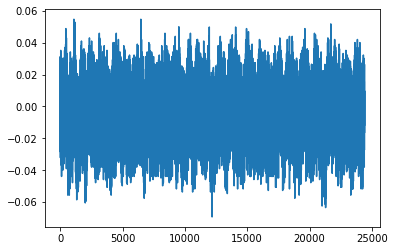

In [35]:
import matplotlib.pylab as plt
plt.plot(trace)

# Encryption without scope capture

In [143]:
import time 

for i in trange (10):

    ################ Initial Communication ########################
    ### send 'R'
    ### receive 'A'
    target.write('R')
    
    while(target.read(1,1000) != 'A'):
        print('waiting A')
        target.read(1,1000)
    
    print('got A')
    
    
    ################ Second Communication ################
    ### send 'P'
    ### receive 'T'
    target.write('P')
    
    while(target.read(1,1000) != 'T'):
        print('waiting T')
        target.read(1,1000)
    
    print('got T')
    
    
    ################ Send PT ################
    for i in range (16):
        time.sleep(0.1)
        pt = bytearray(os.urandom(1))
        target.write(pt)
        #enc_input = target.read(2,10000)
        print(pt)
    enc_input = target.read(32,10000)
    print(enc_input)
    
    while(target.read(1,1000) != 'G'):
        print('waiting G')
        target.read(1,1000)
    
    print('got G')
    
    
    ################ Start Encryption ################
    target.write('S')
    
    time.sleep(0.5)
    
    while(target.read(1,1000) != 'K'):
        print('waiting K')
        target.read(1,1000)
    
    print('got K')
    

    ################ Receive CT ################
    target.write('Q')
    
    time.sleep(0.1)
    
    ct = target.read(32,10000)
    print(ct)
    
    time.sleep(0.1)
    target.write('W')
    print('got W\n')
    time.sleep(0.1)

got A
got T
CWbytearray(b'ff')
CWbytearray(b'4d')
CWbytearray(b'2e')
CWbytearray(b'94')
CWbytearray(b'23')
CWbytearray(b'21')
CWbytearray(b'98')
CWbytearray(b'44')
CWbytearray(b'c7')
CWbytearray(b'02')
CWbytearray(b'be')
CWbytearray(b'6f')
CWbytearray(b'fa')
CWbytearray(b'e9')
CWbytearray(b'55')
CWbytearray(b'5e')
FF4D2E9423219844C702BE6FFAE9555E
got G
got K
4C59481C8FD2A0F5C535853404272491
got W

got A
got T
CWbytearray(b'30')
CWbytearray(b'35')
CWbytearray(b'37')
CWbytearray(b'8c')
CWbytearray(b'6f')
CWbytearray(b'cf')
CWbytearray(b'0e')
CWbytearray(b'9f')
CWbytearray(b'20')
CWbytearray(b'a2')
CWbytearray(b'7f')
CWbytearray(b'63')
CWbytearray(b'fd')
CWbytearray(b'6b')
CWbytearray(b'50')
CWbytearray(b'60')
3035378C6FCF0E9F20A27F63FD6B5060
got G
got K
DC7B2E905832A952E1FE107DEC9EFB26
got W

got A
got T
CWbytearray(b'6c')
CWbytearray(b'7a')
CWbytearray(b'2f')
CWbytearray(b'80')
CWbytearray(b'ed')
CWbytearray(b'27')
CWbytearray(b'16')
CWbytearray(b'85')
CWbytearray(b'31')
CWbytearray(b'6

# Old method

In [ ]:
#import time
#for i in trange (1000):
#    scope.arm()
#    key, text = ktp.next()
#    target.write(cmd+text)
#    ret = scope.capture()
#    if ret:
#        print("Target timed out!")
#        break        
#    trace = scope.get_last_trace()
#    plot.send(trace)
#    traces_enc.append(np.asarray(trace))
#    text_arrays.append(np.asarray(text))
#    key_arrays.append(np.asarray(key)) 